In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import random

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.utils import resample                      # Fare splitting
from sklearn.model_selection import validation_curve

# CLASSIFICAZIONE *RIADMISSION IN 90 DAYS*

In [3]:
df1 = pd.read_csv("df1.csv")

dato che bisogna predire la riammissione entro 90 giorni, vado ad eliminare tutte le feature riguardanti
riammissioni e e il campo della morte

In [4]:
remove_for_r90 = [
'death',
'riad 30d',
'riad 365d', 
'riad +365d',
]

In [5]:
remove_for_r90

['death', 'riad 30d', 'riad 365d', 'riad +365d']

In [6]:
df1.drop(remove_for_r90, axis=1, inplace=True)

In [7]:
df1

,gender,age,riad 90d,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
0,1,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
1,0,52,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,0,1
2,0,52,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
3,0,52,0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
4,0,52,0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521105,0,46,0,1.0,4.0,0.0,0.0,0.0,1.0,2.0,...,0,0,0,0,1,0,1,0,1,0
521106,0,48,0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
521107,1,58,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1
521108,1,58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1


## creo training set, validation set, test set

In [8]:
train, validate, test = np.split(df1.sample(frac=1, random_state=42), [int(.6*len(df1)), int(.7*len(df1))])

## separo le label dai predittori

In [9]:
X_train_r90 = train.drop(["riad 90d"], axis=1)

In [10]:
y_train_r90 = train["riad 90d"]

In [11]:
X_validate_r90 = validate.drop(["riad 90d"], axis=1)

In [12]:
y_validate_r90 = validate["riad 90d"]

In [13]:
X_test_r90 = test.drop(["riad 90d"], axis=1)

In [14]:
y_test_r90 = test["riad 90d"]

controllo che la stratificazione in base alla label sia andata a buon fine:

In [15]:
# proporzione di classi positive (death 1) nel training set
tot_pos_train = len(y_train_r90[y_train_r90 == 1])
prop_pos_train = tot_pos_train / len(y_train_r90) * 100

print('{} % di riammessi entro 90 giorni nel training set'.format(prop_pos_train))
print('{} % di non riammessi entro 90 giorni nel training set'.format(100 - prop_pos_train))

print()

# proporzione di classi negative (death 0) nel validate set
tot_pos_validate = len(y_validate_r90[y_validate_r90 == 1])
prop_pos_validate = tot_pos_validate / len(y_validate_r90) * 100

print('{} % di riammessi entro 90 giorni nel validate set'.format(prop_pos_validate))
print('{} % non di riammessi entro 90 giorni nel validate set'.format(100 - prop_pos_validate))

print()

# proporzione di classi negative (death 0) nel testing set
tot_pos_test = len(y_test_r90[y_test_r90 == 1])
prop_pos_test = tot_pos_test / len(y_test_r90) * 100

print('{} % di riammessi entro 90 giorni ospedaliere nel testing set'.format(prop_pos_test))
print('{} % di non riammessi entro 90 giorni nel testing set'.format(100 - prop_pos_test))

8.899272706338394 % di riammessi entro 90 giorni nel training set
91.1007272936616 % di non riammessi entro 90 giorni nel training set

8.833067874345147 % di riammessi entro 90 giorni nel validate set
91.16693212565485 % non di riammessi entro 90 giorni nel validate set

8.961639577056669 % di riammessi entro 90 giorni ospedaliere nel testing set
91.03836042294333 % di non riammessi entro 90 giorni nel testing set


### standardizzo le features che hanno diverse scale di valori

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_r90_scaled = scaler.fit_transform(X_train_r90)  # fitting and transforming training set
X_train_r90_scaled

array([[-0.96512577, -0.75686884,  0.96630854, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577,  0.69621419, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439,  1.04036543, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       ...,
       [-0.96512577, -0.5656737 , -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [ 1.03613439,  0.35206295, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577, -1.17749813,  2.44962278, ..., -0.87579316,
         1.20438887, -0.32124958]])

## Modelli di classificazione

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [18]:
models = [SGDClassifier, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]
names = ['SGD Classifier', 'Decision Tree Classifier', 'RandomForestClassifier', 'Logistic Regressor']

In [19]:
from sklearn.metrics import accuracy_score

for i in range(len(models)):
    model = models[i](random_state=42)  # inizializzo il modello qui (non ancora addestrato)
    name = names[i] 
    model.fit(X_train_r90_scaled, y_train_r90) # qui addestro il modello sui dati
    y_pred_r90 = model.predict(X_train_r90_scaled)
    print(f'accuracy of {name}: ',accuracy_score(y_pred_r90, y_train_r90))

accuracy of SGD Classifier:  0.9110072729366161
accuracy of Decision Tree Classifier:  0.9984008494687622
accuracy of RandomForestClassifier:  0.998365668157075
accuracy of Logistic Regressor:  0.9110008763344911


anche nella predizione delle riammissioni entro 90 giorni otteniamo apparentemente delle prestazioni elevate ma siamo sempre di fronte  aun dataset sbilanciato

## cross validation

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


names_cv = ['sgd_cv', 'dt_cv', 'rf_cv', 'lr_cv']

for i in range(len(models)):
    avg_acc_models = []
    model = models[i](random_state=42)  # inizializzo il modello qui (non ancora addestrato)
    name = names[i] 
    acc_model = cross_val_score(model, X_train_r90_scaled, y_train_r90, cv=3, scoring='accuracy')
    avg_acc_model = acc_model.mean()
    avg_acc_models.append(avg_acc_model)
    print(f'accuracy of {name}: ', avg_acc_model)

accuracy of SGD Classifier:  0.9109976780334286
accuracy of Decision Tree Classifier:  0.8346830163816982
accuracy of RandomForestClassifier:  0.9096479949850639
accuracy of Logistic Regressor:  0.9110008763344911


## analisi sui singoli modelli: SGD, DT, RF, LR
procedo ad analizzarli uno per uno esaminando le predizioni fatte tramite cross validation\
questa volta utilizzo *5-fold cross validation* per ogni modello

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

### analisi specifica su SGD Classifier

In [22]:
sgd_cv = SGDClassifier(random_state=42)
y_pred_sgd_cv = cross_val_predict(sgd_cv, X_train_r90_scaled, y_train_r90, cv=5)
score_sgd_cv = accuracy_score(y_train_r90, y_pred_sgd_cv)

In [23]:
list(y_pred_sgd_cv).count(1)  # numero di predizioni di riammissioni entro 90 giorni

50

In [24]:
score_sgd_cv

0.910885737496242

### confusion matrix SGD

In [25]:
cm_r90_sgd = confusion_matrix(y_train_r90, y_pred_sgd_cv)
cm_r90_sgd

array([[284797,     44],
       [ 27819,      6]], dtype=int64)

In [26]:
print("PREDIZIONI STOCHASTIC GRADIENT DESCENT CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r90_sgd[1,1]))
print("{} veri negativi".format(cm_r90_sgd[0,0]))
print("{} falsi positivi".format(cm_r90_sgd[0,1]))
print("{} falsi negativi".format(cm_r90_sgd[1,0]))

PREDIZIONI STOCHASTIC GRADIENT DESCENT CON CROSS VALIDATION
6 veri positivi
284797 veri negativi
44 falsi positivi
27819 falsi negativi


In [27]:
ps_sgd = precision_score(y_train_r90, y_pred_sgd_cv)
rs_sgd = recall_score(y_train_r90, y_pred_sgd_cv)
f1_sgd = f1_score(y_train_r90, y_pred_sgd_cv)

### analisi più specifica sul Random Forest Classifier

In [28]:
 rf_cv = RandomForestClassifier(random_state=42)
 y_pred_rf_cv = cross_val_predict(rf_cv, X_train_r90_scaled, y_train_r90, cv=5)
 score_rf_cv = accuracy_score(y_train_r90, y_pred_rf_cv)

In [29]:
 list(y_pred_rf_cv).count(1)  # numero di predizioni di morti ospedaliere

590

In [30]:
 score_rf_cv

0.9096000204691268

### confusion matrix RF

In [31]:
 cm_r90_rf = confusion_matrix(y_train_r90, y_pred_rf_cv)
 cm_r90_rf

array([[284326,    515],
       [ 27750,     75]], dtype=int64)

In [32]:
 print("PREDIZIONI RANDOM FOREST CLASSIFIER CON CROSS VALIDATION")
 print("{} veri positivi".format(cm_r90_rf[1,1]))
 print("{} veri negativi".format(cm_r90_rf[0,0]))
 print("{} falsi positivi".format(cm_r90_rf[0,1]))
 print("{} falsi negativi".format(cm_r90_rf[1,0]))

PREDIZIONI RANDOM FOREST CLASSIFIER CON CROSS VALIDATION
75 veri positivi
284326 veri negativi
515 falsi positivi
27750 falsi negativi


In [33]:
ps_rf = precision_score(y_train_r90, y_pred_rf_cv)
rs_rf = recall_score(y_train_r90, y_pred_rf_cv)
f1_rf = f1_score(y_train_r90, y_pred_rf_cv)

Rispetto al Stochastic gradient Descent, il Random Forest predice piu riammissioni, ma comunque
molto poche

### analisi più specifica sul Logistic Regressor

In [34]:
lr_cv = LogisticRegression(random_state=42)
y_pred_lr_cv = cross_val_predict(lr_cv, X_train_r90_scaled, y_train_r90, cv=5)
score_lr_cv = accuracy_score(y_train_r90, y_pred_lr_cv)

In [35]:
list(y_pred_lr_cv).count(1)  # numero di predizioni di morti ospedaliere

2

In [36]:
score_lr_cv

0.9110008763344911

### confusion matrix LR

In [37]:
cm_r90_lr = confusion_matrix(y_train_r90, y_pred_lr_cv)
cm_r90_lr

array([[284839,      2],
       [ 27825,      0]], dtype=int64)

In [38]:
print("PREDIZIONI LOGISTIC REGRESSOR CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r90_lr[1,1]))
print("{} veri negativi".format(cm_r90_lr[0,0]))
print("{} falsi positivi".format(cm_r90_lr[0,1]))
print("{} falsi negativi".format(cm_r90_lr[1,0]))

PREDIZIONI LOGISTIC REGRESSOR CON CROSS VALIDATION
0 veri positivi
284839 veri negativi
2 falsi positivi
27825 falsi negativi


In [39]:
ps_lr = precision_score(y_train_r90, y_pred_lr_cv)
rs_lr = recall_score(y_train_r90, y_pred_lr_cv)
f1_lr = f1_score(y_train_r90, y_pred_lr_cv)
print('precision score is {}'.format(ps_lr))
print('recall score is {}'.format(rs_lr))
print('f1 score is {}'.format(f1_lr))

precision score is 0.0
recall score is 0.0
f1 score is 0.0


### precision, recall, f1 del Logistic Regressor

In [40]:
ps_lr = precision_score(y_train_r90, y_pred_lr_cv)
rs_lr = recall_score(y_train_r90, y_pred_lr_cv)
f1_lr = f1_score(y_train_r90, y_pred_lr_cv)
print('precision score is {}'.format(ps_lr))
print('recall score is {}'.format(rs_lr))
print('f1 score is {}'.format(f1_lr))

precision score is 0.0
recall score is 0.0
f1 score is 0.0


### analisi più specifica sul Decision Tree

In [41]:
dt_cv = DecisionTreeClassifier(random_state=42)
y_pred_dt_cv = cross_val_predict(dt_cv, X_train_r90_scaled, y_train_r90, cv=5)
score_dt_cv = accuracy_score(y_train_r90, y_pred_dt_cv)

In [42]:
score_dt_cv

0.8352874952825059

### confusion matrix DT

In [43]:
cm_r90_dt = confusion_matrix(y_train_r90, y_pred_dt_cv)
cm_r90_dt

array([[256824,  28017],
       [ 23483,   4342]], dtype=int64)

In [44]:
print("PREDIZIONI DECISION TREE CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r90_dt[1,1]))
print("{} veri negativi".format(cm_r90_dt[0,0]))
print("{} falsi positivi".format(cm_r90_dt[0,1]))
print("{} falsi negativi".format(cm_r90_dt[1,0]))

PREDIZIONI DECISION TREE CON CROSS VALIDATION
4342 veri positivi
256824 veri negativi
28017 falsi positivi
23483 falsi negativi


### precision, recall, f1 del Decision Tree

In [45]:
ps_dt = precision_score(y_train_r90, y_pred_dt_cv)
rs_dt = recall_score(y_train_r90, y_pred_dt_cv)
f1_dt = f1_score(y_train_r90, y_pred_dt_cv)
print('precision score is {}'.format(ps_dt))
print('recall score is {}'.format(rs_dt))
print('f1 score is {}'.format(f1_dt))

precision score is 0.13418214407120121
recall score is 0.15604672057502247
f1 score is 0.14429084141964643


# Commenti post crossvalidation

il dataset è sempre sbilanciato e i valori di precision, recall e f1 score sono sempre molto bassi, effettuiamo nuovamente l'oversampling per vedere se aumentano anche in questo caso

## OVERSAMPLING

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
eq = SMOTE()
X_train_r90_ov, y_train_r90_ov = eq.fit_resample(X_train_r90_scaled, y_train_r90.ravel())  # reshape 1D flatten

### risultati oversampling

In [48]:
len(X_train_r90_ov)  # nuova lunghezza del dataset

569682

In [49]:
list(y_train_r90).count(1) # numero di morti ospedaliere PRIMA dell'oversampling

27825

In [50]:
list(y_train_r90_ov).count(1) # numero di morti ospedaliere DOPO l'oversampling

284841

In [51]:
list(y_train_r90).count(0) # numero di sopravvissuti PRIMA dell'oversampling

284841

In [52]:
list(y_train_r90_ov).count(0) # numero di sopravvissuti DOPO l'oversampling

284841

## Nuove Predizioni POST oversampling

### Decision Tree

In [53]:
dt = DecisionTreeClassifier(random_state=42)

In [54]:
y_pred_dt_cv_ov = cross_val_predict(dt, X_train_r90_ov, y_train_r90_ov, cv=3)
score_dt_ov = accuracy_score(y_train_r90_ov, y_pred_dt_cv_ov)

In [55]:
score_dt_ov

0.9020681713657795

In [56]:
cm_dt_ov = confusion_matrix(y_train_r90_ov, y_pred_dt_cv_ov)
ps_dt_ov = precision_score(y_train_r90_ov, y_pred_dt_cv_ov)
rs_dt_ov = recall_score(y_train_r90_ov, y_pred_dt_cv_ov)
f1_dt_ov = f1_score(y_train_r90_ov, y_pred_dt_cv_ov)

In [57]:
perf_dt = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_dt,rs_dt,f1_dt],
        'post-oversampling': [ps_dt_ov, rs_dt_ov, f1_dt_ov]
        }

In [58]:
table_dt = pd.DataFrame(perf_dt, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_dt.style.set_table_attributes("style='display:inline'").set_caption('DECISION TREE PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.134182,0.904237
1,recall,0.156047,0.899386
2,f1,0.144291,0.901805


### Logistic Regressor

In [59]:
lr = LogisticRegression(random_state=42)

In [60]:
y_pred_lr_cv_ov = cross_val_predict(lr, X_train_r90_ov, y_train_r90_ov, cv=3)
score_lr_ov = accuracy_score(y_train_r90_ov, y_pred_lr_cv_ov)

In [61]:
score_lr_ov

0.6425251280538967

In [62]:
cm_lr_ov = confusion_matrix(y_train_r90_ov, y_pred_lr_cv_ov)
ps_lr_ov = precision_score(y_train_r90_ov, y_pred_lr_cv_ov)
rs_lr_ov = recall_score(y_train_r90_ov, y_pred_lr_cv_ov)
f1_lr_ov = f1_score(y_train_r90_ov, y_pred_lr_cv_ov)

In [63]:
perf_lr = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_lr,rs_lr,f1_lr],
        'post-oversampling': [ps_lr_ov, rs_lr_ov, f1_lr_ov]
        }

In [64]:
table_lr = pd.DataFrame(perf_lr, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_lr.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSION PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.000000,0.618005
1,recall,0.000000,0.746420
2,f1,0.000000,0.676169


### Random Forest

In [65]:
rf = RandomForestClassifier(random_state=42)

In [66]:
y_pred_rf_cv_ov = cross_val_predict(rf, X_train_r90_ov, y_train_r90_ov, cv=3)
score_rf_ov = accuracy_score(y_train_r90_ov, y_pred_rf_cv_ov)

In [67]:
score_rf_ov

0.9476778272790785

In [68]:
cm_rf_ov = confusion_matrix(y_train_r90_ov, y_pred_rf_cv_ov)
ps_rf_ov = precision_score(y_train_r90_ov, y_pred_rf_cv_ov)
rs_rf_ov = recall_score(y_train_r90_ov, y_pred_rf_cv_ov)
f1_rf_ov = f1_score(y_train_r90_ov, y_pred_rf_cv_ov)

In [69]:
perf_rf = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_rf,rs_rf,f1_rf],
        'post-oversampling': [ps_rf_ov, rs_rf_ov, f1_rf_ov]
        }

In [70]:
table_rf = pd.DataFrame(perf_rf, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_rf.style.set_table_attributes("style='display:inline'").set_caption('RANDOM FOREST PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.127119,0.994509
1,recall,0.002695,0.900327
2,f1,0.005279,0.945077


# Considerazioni post oversampling
anche questa volta dopo l'oversampling si può notare un netto miglioramento almeno apparentemente dei valori di precision, recall e f1 score

## Predizioni sul validation set
andiamo nuovamente a verificare le prestazioni sul validation set

In [71]:
X_validate_r90  # il validation set mai visto dal modello, che bisogna però scalare

,gender,age,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,icd_D_nervous_system,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
300792,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
274325,0,55,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,1,1,0,0
185779,0,63,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
117038,1,53,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
290892,0,29,1.0,5.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108278,1,39,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0
127414,1,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
196974,1,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
245347,0,61,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,1,0,0


In [72]:
y_validate_r90  # questi sono i dati su cui verrà calcolato l'accuracy score finale

300792    0
274325    0
185779    0
117038    0
290892    0
         ..
108278    1
127414    0
196974    0
245347    1
465409    0
Name: riad 90d, Length: 52111, dtype: int64

In [73]:
X_validate_r90_scaled = scaler.transform(X_validate_r90)  # fitting and transforming validation set
X_validate_r90_scaled

array([[-0.96512577, -1.9805177 , -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.12262879, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.428541  , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       ...,
       [ 1.03613439, -1.9805177 , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577,  0.35206295, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.8491703 , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958]])

### Random Forest

In [74]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_r90_ov, y_train_r90_ov)

RandomForestClassifier(random_state=42)

In [75]:
validation_pred_rf = rf.predict(X_validate_r90_scaled)
validation_pred_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
acc_rf = accuracy_score(y_validate_r90, validation_pred_rf)
acc_rf

0.9083878643664486

In [77]:
cm_rf_validation = confusion_matrix(y_validate_r90, validation_pred_rf)
ps_rf_validation = precision_score(y_validate_r90, validation_pred_rf)
rs_rf_validation = recall_score(y_validate_r90, validation_pred_rf)
f1_rf_validation = f1_score(y_validate_r90, validation_pred_rf)

In [78]:
perf_rf_validation = {
           'Metric': ['precision','recall','f1'],
           'validation': [ps_rf_validation, rs_rf_validation, f1_rf_validation]
          }

In [79]:
table_rf_validation = pd.DataFrame(perf_rf_validation, columns = ['Metric', 'validation'])
table_rf_validation.style.set_table_attributes("style='display:inline'").set_caption('RANDOM FOREST VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.116592
1,recall,0.005648
2,f1,0.010775


In [80]:
print("{} veri positivi".format(cm_rf_validation[1,1]))
print("{} veri negativi".format(cm_rf_validation[0,0]))
print("{} falsi positivi".format(cm_rf_validation[0,1]))
print("{} falsi negativi".format(cm_rf_validation[1,0]))

26 veri positivi
47311 veri negativi
197 falsi positivi
4577 falsi negativi


### Logistic Regressor

In [81]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_r90_ov, y_train_r90_ov)

LogisticRegression(random_state=42)

In [82]:
validation_pred_lr = lr.predict(X_validate_r90_scaled)
validation_pred_lr

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [83]:
acc_lr = accuracy_score(y_validate_r90, validation_pred_lr)
acc_lr

0.5547005430715204

In [84]:
cm_lr_validation = confusion_matrix(y_validate_r90, validation_pred_lr)
ps_lr_validation = precision_score(y_validate_r90, validation_pred_lr)
rs_lr_validation = recall_score(y_validate_r90, validation_pred_lr)
f1_lr_validation = f1_score(y_validate_r90, validation_pred_lr)

In [85]:
perf_lr_validation = {
                   'Metric': ['precision','recall','f1'],
                   'validation': [ps_lr_validation, rs_lr_validation, f1_lr_validation]
                 }

In [86]:
table_lr_validation = pd.DataFrame(perf_lr_validation, columns = ['Metric', 'validation'])
table_lr_validation.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSOR VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.133732
1,recall,0.737780
2,f1,0.226423


In [87]:
print("{} veri positivi".format(cm_lr_validation[1,1]))
print("{} veri negativi".format(cm_lr_validation[0,0]))
print("{} falsi positivi".format(cm_lr_validation[0,1]))
print("{} falsi negativi".format(cm_lr_validation[1,0]))

3396 veri positivi
25510 veri negativi
21998 falsi positivi
1207 falsi negativi


### Decision Tree

In [88]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_r90_ov, y_train_r90_ov)

DecisionTreeClassifier(random_state=42)

In [89]:
validation_pred_dt = dt.predict(X_validate_r90_scaled)
validation_pred_dt

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
acc_dt = accuracy_score(y_validate_r90, validation_pred_dt)
acc_dt

0.8323578515092783

In [91]:
cm_dt_validation = confusion_matrix(y_validate_r90, validation_pred_dt)
ps_dt_validation = precision_score(y_validate_r90, validation_pred_dt)
rs_dt_validation = recall_score(y_validate_r90, validation_pred_dt)
f1_dt_validation = f1_score(y_validate_r90, validation_pred_dt)

In [92]:
perf_dt_validation = {
                   'Metric': ['precision','recall','f1'],
                   'validation': [ps_dt_validation, rs_dt_validation, f1_dt_validation]
                 }

In [93]:
table_dt_validation = pd.DataFrame(perf_dt_validation, columns = ['Metric', 'validation'])
table_dt_validation.style.set_table_attributes("style='display:inline'").set_caption('DECISION TREE VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.122281
1,recall,0.145340
2,f1,0.132817


In [94]:
print("{} veri positivi".format(cm_dt_validation[1,1]))
print("{} veri negativi".format(cm_dt_validation[0,0]))
print("{} falsi positivi".format(cm_dt_validation[0,1]))
print("{} falsi negativi".format(cm_dt_validation[1,0]))

669 veri positivi
42706 veri negativi
4802 falsi positivi
3934 falsi negativi


# considerazioni post validation

il modello che pare essere più bilanciato tra precision e recall è decision tre mentre quello che in generale ha un f1 score maggiore il logistic regressor 

## HYPERPARAMETERS TUNING

vediamo se questa volta è possibile migliorare le predizioni con il tuning per la random forest e il logistic regressor

### Random Forest

#### tuning del n_estimators (default = 100)

In [95]:
num_est = [1, 10, 50, 100]

In [96]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r90_ov, y = y_train_r90_ov, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

In [97]:
train_scoreNum

array([[0.97803511, 0.94496403, 0.94467176],
       [0.99927854, 0.99107397, 0.991124  ],
       [0.99979726, 0.99873877, 0.99879406],
       [0.99981305, 0.99886252, 0.99891518]])

In [98]:
test_scoreNum

array([[0.82871497, 0.90360938, 0.90038127],
       [0.85080624, 0.98946254, 0.98934142],
       [0.85262304, 0.99501301, 0.99475497],
       [0.85290215, 0.99519732, 0.99500774]])

In [99]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [100]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

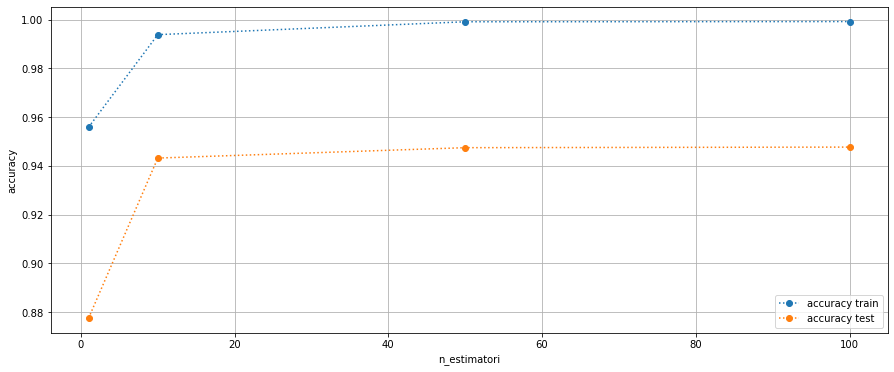

In [101]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(num_est,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(num_est,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('n_estimatori')
ax.grid()
ax.legend()

#### tuning max_depth (deault none)

In [102]:
max_depth = [1, 10, 25, 50, 100, 200]

In [103]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r90_ov, y = y_train_r90_ov, 
                                param_name = 'max_depth', 
                                param_range = max_depth, cv = 3)

In [104]:
train_scoreNum

array([[0.6743657 , 0.64919903, 0.65475212],
       [0.95584905, 0.8775738 , 0.88391418],
       [0.99645592, 0.97779287, 0.97719254],
       [0.99981305, 0.99886252, 0.99890729],
       [0.99981042, 0.99886779, 0.99891255],
       [0.99981042, 0.99885726, 0.99891255]])

In [105]:
test_scoreNum

array([[0.65228496, 0.65664529, 0.66350701],
       [0.82536046, 0.93265717, 0.94334208],
       [0.85064299, 0.99494455, 0.9947655 ],
       [0.85295481, 0.99528684, 0.99505514],
       [0.85280209, 0.99547116, 0.99508147],
       [0.85271783, 0.9953711 , 0.99492348]])

In [106]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [107]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

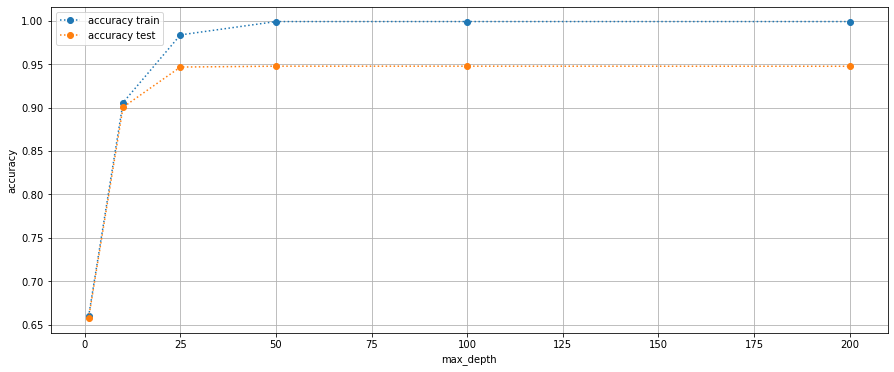

In [108]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(max_depth,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(max_depth,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('max_depth')
ax.grid()
ax.legend()

#### tuning min_samples_split (default = 2)

In [109]:
min_samples_split = [1, 2, 3, 4, 5]

In [110]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r90_ov, y = y_train_r90_ov, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split, cv = 3)

In [111]:
train_scoreNum

array([[       nan,        nan,        nan],
       [0.99980779, 0.99886516, 0.99891518],
       [0.99966824, 0.99735379, 0.99741435],
       [0.99931277, 0.99276702, 0.99300399],
       [0.9991153 , 0.98702961, 0.98731134]])

In [112]:
test_scoreNum

array([[       nan,        nan,        nan],
       [0.85278629, 0.99528684, 0.99503407],
       [0.85252299, 0.99589245, 0.99563967],
       [0.85215436, 0.99611362, 0.99595564],
       [0.85201744, 0.99606096, 0.99611889]])

In [113]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [114]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

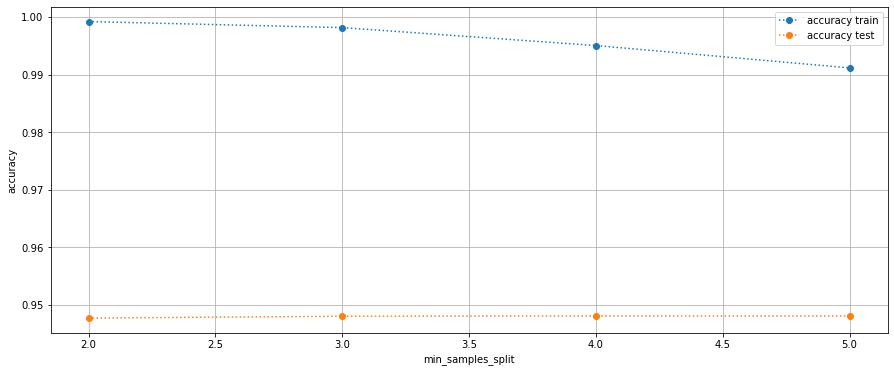

In [115]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(min_samples_split,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(min_samples_split,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('min_samples_split')
ax.grid()
ax.legend()

#### tuning min_samples_leaf (default = 1)

In [116]:
min_samples_leaf = [1, 2, 3, 4, 5]

In [117]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r90_ov, y = y_train_r90_ov, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf, cv = 3)

In [118]:
train_scoreNum

array([[0.99981042, 0.99885726, 0.99891782],
       [0.99777244, 0.96849295, 0.96899849],
       [0.99655071, 0.94385289, 0.94405563],
       [0.9956739 , 0.93411061, 0.93432652],
       [0.99487082, 0.92951857, 0.92951857]])

In [119]:
test_scoreNum

array([[0.85275996, 0.99530264, 0.99503934],
       [0.85070618, 0.99576079, 0.9956818 ],
       [0.84980568, 0.99479183, 0.99508147],
       [0.84914742, 0.99452326, 0.99477077],
       [0.8484207 , 0.99375441, 0.99387026]])

In [120]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [121]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

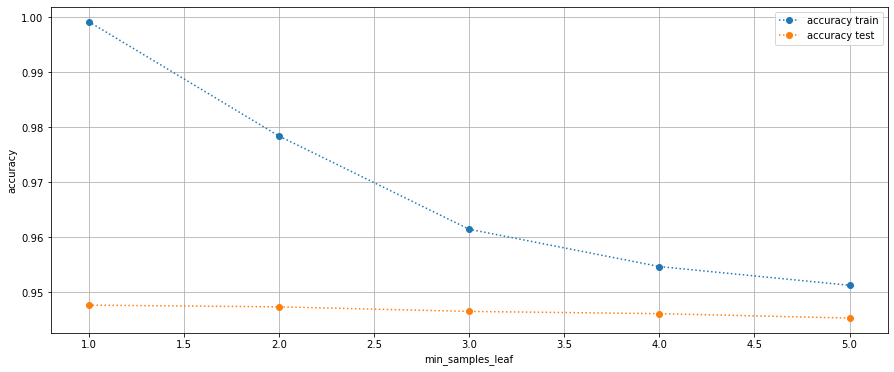

In [122]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(min_samples_leaf,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(min_samples_leaf,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('min_samples_leaf')
ax.grid()
ax.legend()

### Logistic Regressor

#### tuning del tol (default = 100)

In [123]:
tol = [0.000001, 0.00001, 0.0001, 0.001, 0.01]

In [124]:
train_scoreNum, test_scoreNum = validation_curve(
                                LogisticRegression(),
                                X = X_train_r90_ov, y = y_train_r90_ov, 
                                param_name = 'tol', 
                                param_range = tol, cv = 3)

In [125]:
train_scoreNum

array([[0.6429587 , 0.64298767, 0.64291131],
       [0.6429587 , 0.64298767, 0.64291131],
       [0.6429587 , 0.64298767, 0.64291131],
       [0.6429587 , 0.64298767, 0.64291131],
       [0.6429587 , 0.64298767, 0.64291131]])

In [126]:
test_scoreNum

array([[0.64146313, 0.64345372, 0.64265854],
       [0.64146313, 0.64345372, 0.64265854],
       [0.64146313, 0.64345372, 0.64265854],
       [0.64146313, 0.64345372, 0.64265854],
       [0.64146313, 0.64345372, 0.64265854]])

In [127]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [128]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

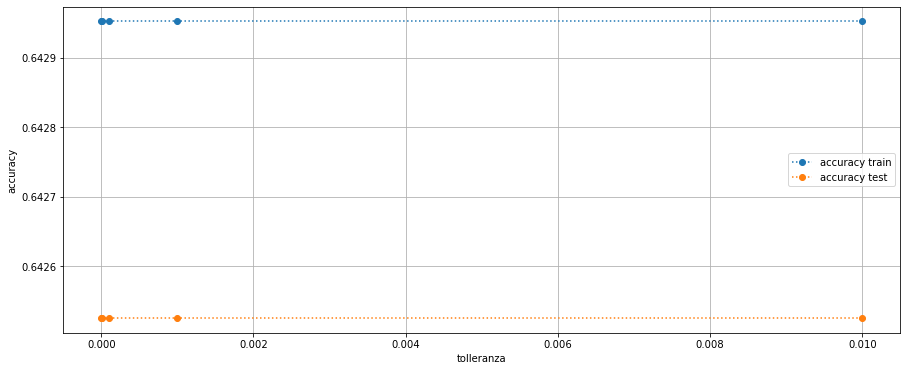

In [129]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(tol,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(tol,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('tolleranza')
ax.grid()
ax.legend()

### Logistic Regressor

#### tuning del C (default = 100)

In [130]:
C = [0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0]

In [131]:
train_scoreNum, test_scoreNum = validation_curve(
                                LogisticRegression(),
                                X = X_train_r90_ov, y = y_train_r90_ov, 
                                param_name = 'C', 
                                param_range = C, cv = 3)

In [132]:
train_scoreNum

array([[0.64307192, 0.6429903 , 0.64283495],
       [0.64301926, 0.64300083, 0.64290604],
       [0.6429587 , 0.64298767, 0.64291131],
       [0.64303506, 0.64296134, 0.64289551],
       [0.64308772, 0.6429903 , 0.64288498],
       [0.64306403, 0.64289024, 0.64292447],
       [0.64300347, 0.64291394, 0.64289551]])

In [133]:
test_scoreNum

array([[0.6414842 , 0.64355904, 0.64254268],
       [0.64141574, 0.64342739, 0.64265854],
       [0.64146313, 0.64345372, 0.64265854],
       [0.6414368 , 0.64352218, 0.64260061],
       [0.64144733, 0.64338526, 0.64268487],
       [0.6414368 , 0.64347478, 0.64265327],
       [0.64153159, 0.64343792, 0.64269013]])

In [134]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [135]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

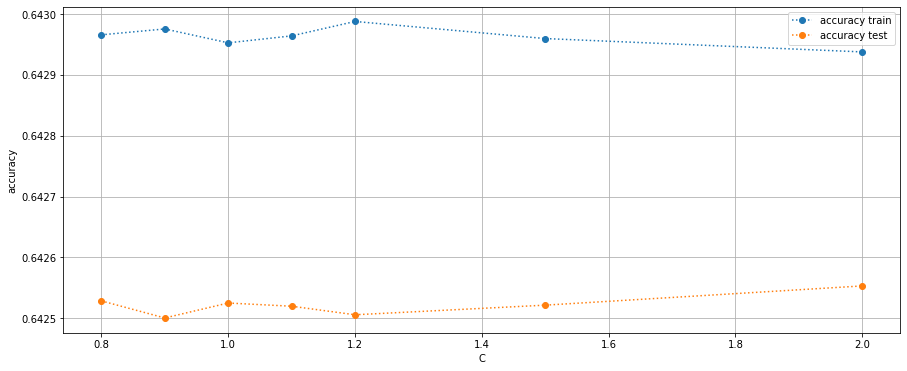

In [136]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(C,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(C,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('C')
ax.grid()
ax.legend()

# Predizioni finali sul test ( modello scelto logistic regressor)
applico il modello scelto al test set

In [137]:
X_test_r90  # il test set mai visto dal modello, che bisogna però scalare

,gender,age,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,icd_D_nervous_system,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
465869,0,46,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0
416293,0,48,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
98968,0,60,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
254219,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0
4251,0,43,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,84,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
365838,1,59,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
131932,1,57,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,1,0
146867,1,33,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0


In [138]:
y_test_r90  # questi sono i dati su cui verrà calcolato l'accuracy score finale

465869    0
416293    1
98968     0
254219    0
4251      0
         ..
259178    0
365838    0
131932    0
146867    0
121958    1
Name: riad 90d, Length: 156333, dtype: int64

In [139]:
X_test_r90_scaled = scaler.transform(X_test_r90)  # fitting and transforming training set
X_test_r90_scaled

array([[-0.96512577, -0.22152246, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577, -0.1450444 ,  0.96630854, ..., -0.87579316,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.31382392, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       ...,
       [ 1.03613439,  0.19910684, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439, -0.71862981, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439,  1.15508251,  3.93293702, ..., -0.87579316,
        -0.83029661,  3.11284458]])

In [140]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_r90_ov, y_train_r90_ov)

LogisticRegression(random_state=42)

In [141]:
final_pred_lr = lr.predict(X_test_r90_scaled)
final_pred_lr

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [142]:
acc_lr = accuracy_score(y_test_r90, final_pred_lr)
acc_lr

0.5557176028093876

In [143]:
cm_lr_final = confusion_matrix(y_test_r90, final_pred_lr)
ps_lr_final = precision_score(y_test_r90, final_pred_lr)
rs_lr_final = recall_score(y_test_r90, final_pred_lr)
f1_lr_final = f1_score(y_test_r90, final_pred_lr)

In [144]:
perf_lr_final = {
                   'Metric': ['precision','recall','f1'],
                   'final': [ps_lr_final, rs_lr_final, f1_lr_final]
                 }

In [145]:
table_lr_final = pd.DataFrame(perf_lr_final, columns = ['Metric', 'final'])
table_lr_final.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSOR FINAL PERFORMANCES')

,Metric,final
0,precision,0.134608
1,recall,0.728979
2,f1,0.227254


In [146]:
print("{} veri positivi".format(cm_lr_final[1,1]))
print("{} veri negativi".format(cm_lr_final[0,0]))
print("{} falsi positivi".format(cm_lr_final[0,1]))
print("{} falsi negativi".format(cm_lr_final[1,0]))

10213 veri positivi
76664 veri negativi
65659 falsi positivi
3797 falsi negativi


ancora una volta tra i vari modelli il logistic regressor tende a massimizzare la recall anche se in questo caso è più difficile definire se è preferibile massimizzare la recall e accontentarci su precision e accuracy 